<a href="https://colab.research.google.com/github/onurercen/workout_prediction_app/blob/main/decision_tree_workout_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab için gerekli kurulumlar
!pip install imbalanced-learn -q

# Veri setini yükle
from google.colab import files
uploaded = files.upload()

Saving gym_members_exercise_tracking.csv to gym_members_exercise_tracking.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Veri yükleme
df = pd.read_csv("gym_members_exercise_tracking.csv")
df = df.dropna()
df.reset_index(drop=True, inplace=True)

print("="*70)
print("WORKOUT TYPE PREDICTION - DECISION TREE MODEL")
print("="*70)
print(f"\nVeri seti boyutu: {df.shape}")

WORKOUT TYPE PREDICTION - DECISION TREE MODEL

Veri seti boyutu: (973, 15)


In [4]:
# Target analizi
print("\nWorkout Type Dağılımı:")
print(df["Workout_Type"].value_counts())
print(f"\nWorkout Type oranları:")
print(df["Workout_Type"].value_counts(normalize=True))


Workout Type Dağılımı:
Workout_Type
Strength    258
Cardio      255
Yoga        239
HIIT        221
Name: count, dtype: int64

Workout Type oranları:
Workout_Type
Strength    0.265159
Cardio      0.262076
Yoga        0.245632
HIIT        0.227133
Name: proportion, dtype: float64


In [5]:
# FEATURE ENGINEERING
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

df["HR_per_minute"] = df["Avg_BPM"] / (df["Session_Duration (hours)"] * 60)
df["Intensity_per_Weight"] = df["Calories_Burned"] / df["Weight (kg)"]
df["HRR"] = df["Max_BPM"] - df["Resting_BPM"]
df["Efficiency"] = df["Calories_Burned"] / df["Avg_BPM"]
df["Experience_Adjusted_Calories"] = df["Calories_Burned"] / (df["Experience_Level"] + 1)
df["Anaerobic_Index"] = (df["Max_BPM"] - df["Avg_BPM"]) / df["Resting_BPM"]
df["BPM_Variance_Rest"] = (df["Avg_BPM"] - df["Resting_BPM"]) ** 2
df["Heart_Instability"] = abs(df["Max_BPM"] - df["Avg_BPM"]) / df["Max_BPM"]
df["Calories_per_Hour"] = df["Calories_Burned"] / df["Session_Duration (hours)"]
df["Heart_Efficiency"] = df["Calories_Burned"] / df["HRR"]
df["BMI_Category"] = pd.cut(df["BMI"], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df["Age_Group"] = pd.cut(df["Age"], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)

print("12 yeni feature oluşturuldu")


FEATURE ENGINEERING
12 yeni feature oluşturuldu


In [7]:
# Label Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()

df["Gender_Code"] = le_gender.fit_transform(df["Gender"])
df["Workout_Code"] = le_workout.fit_transform(df["Workout_Type"])

print(f"Workout Types: {dict(zip(le_workout.classes_, range(len(le_workout.classes_))))}")

Workout Types: {'Cardio': 0, 'HIIT': 1, 'Strength': 2, 'Yoga': 3}


In [8]:
# Feature Selection - Workout_Type ÇIKARILIYOR (target olacak)
feature_cols = [
    'Age', 'Gender_Code', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Experience_Level', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Experience_Adjusted_Calories', 'Anaerobic_Index', 'BPM_Variance_Rest',
    'Heart_Instability', 'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group'
]

X = df[feature_cols]
y = df['Workout_Code']

print(f"\nFeature sayısı: {X.shape[1]}")
print(f"Target: Workout_Type")


Feature sayısı: 26
Target: Workout_Type


In [9]:
# Split (SVM ile aynı: %80-%20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Train set: (778, 26)
Test set: (195, 26)


In [10]:
# Class dağılımı
print("\nTrain set dağılımı:")
print(pd.Series(y_train).value_counts().sort_index())


Train set dağılımı:
Workout_Code
0    204
1    177
2    206
3    191
Name: count, dtype: int64


In [11]:
# DECISION TREE MODEL
print("\n" + "="*70)
print("DECISION TREE MODEL EĞİTİMİ")
print("="*70)

# Baseline model
dt_model = DecisionTreeClassifier(
    random_state=42,
    criterion='gini',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

print("Model eğitiliyor...")
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y_train, dt_model.predict(X_train))

print("\n" + "="*70)
print("BASELINE MODEL PERFORMANSI")
print("="*70)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_workout.classes_))

print(f"\n📊 Overfitting Kontrolü:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy:  {accuracy:.4f}")
print(f"   Fark: {train_acc - accuracy:.4f}")


DECISION TREE MODEL EĞİTİMİ
Model eğitiliyor...

BASELINE MODEL PERFORMANSI

Accuracy: 0.2308 (23.08%)

Classification Report:
              precision    recall  f1-score   support

      Cardio       0.19      0.12      0.14        51
        HIIT       0.24      0.43      0.31        44
    Strength       0.27      0.31      0.29        52
        Yoga       0.17      0.08      0.11        48

    accuracy                           0.23       195
   macro avg       0.22      0.24      0.21       195
weighted avg       0.22      0.23      0.21       195


📊 Overfitting Kontrolü:
   Train Accuracy: 0.5848
   Test Accuracy:  0.2308
   Fark: 0.3541


In [12]:
# Cross-Validation
print("\n" + "="*70)
print("CROSS-VALIDATION (5-Fold)")
print("="*70)

cv_scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
print(f"\nCV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


CROSS-VALIDATION (5-Fold)

CV Scores: [0.28205128 0.30769231 0.24615385 0.28865979 0.34020619]
Mean CV Accuracy: 0.2930 (+/- 0.0618)


In [13]:
# GridSearchCV
print("\n" + "="*70)
print("HYPERPARAMETER TUNING (GridSearchCV)")
print("="*70)

param_grid = {
    'max_depth': [3, 5, 8, 10, 12, 15, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Grid Search başlatılıyor...")
grid_search.fit(X_train, y_train)

print(f"\nEn iyi parametreler: {grid_search.best_params_}")
print(f"En iyi CV accuracy: {grid_search.best_score_:.4f}")


HYPERPARAMETER TUNING (GridSearchCV)
Grid Search başlatılıyor...
Fitting 5 folds for each of 350 candidates, totalling 1750 fits

En iyi parametreler: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
En iyi CV accuracy: 0.2841


In [15]:
# En iyi model
best_dt_model = grid_search.best_estimator_
y_pred_best = best_dt_model.predict(X_test)

best_accuracy = accuracy_score(y_test, y_pred_best)
best_train_acc = accuracy_score(y_train, best_dt_model.predict(X_train))

print("\n" + "="*70)
print("OPTİMİZE EDİLMİŞ MODEL PERFORMANSI")
print("="*70)
print(f"\nAccuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

print("\nClassification Report (Optimized):")
print(classification_report(y_test, y_pred_best, target_names=le_workout.classes_))

print(f"\n Overfitting Kontrolü (Optimized):")
print(f"   Train Accuracy: {best_train_acc:.4f}")
print(f"   Test Accuracy:  {best_accuracy:.4f}")
print(f"   Fark: {best_train_acc - best_accuracy:.4f}")

if best_train_acc - best_accuracy > 0.05:
    print("Overfitting riski var!")
else:
    print("Overfitting yok")


OPTİMİZE EDİLMİŞ MODEL PERFORMANSI

Accuracy: 0.2359 (23.59%)

Classification Report (Optimized):
              precision    recall  f1-score   support

      Cardio       0.23      0.18      0.20        51
        HIIT       0.22      0.18      0.20        44
    Strength       0.27      0.38      0.32        52
        Yoga       0.20      0.19      0.20        48

    accuracy                           0.24       195
   macro avg       0.23      0.23      0.23       195
weighted avg       0.23      0.24      0.23       195


 Overfitting Kontrolü (Optimized):
   Train Accuracy: 0.8535
   Test Accuracy:  0.2359
   Fark: 0.6176
Overfitting riski var!


In [16]:
# Feature Importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Önemli Feature:")
print(feature_importance.head(15).to_string(index=False))


FEATURE IMPORTANCE

Top 15 Önemli Feature:
                     Feature  Importance
              Fat_Percentage    0.086543
                         BMI    0.083713
Experience_Adjusted_Calories    0.063941
           BPM_Variance_Rest    0.060340
            Heart_Efficiency    0.060013
               HR_per_minute    0.053587
                 Weight (kg)    0.052650
                         Age    0.050258
                  Height (m)    0.049149
                     Avg_BPM    0.044707
                         HRR    0.044183
             Anaerobic_Index    0.042799
       Water_Intake (liters)    0.039900
                     Max_BPM    0.039742
        Intensity_per_Weight    0.039066


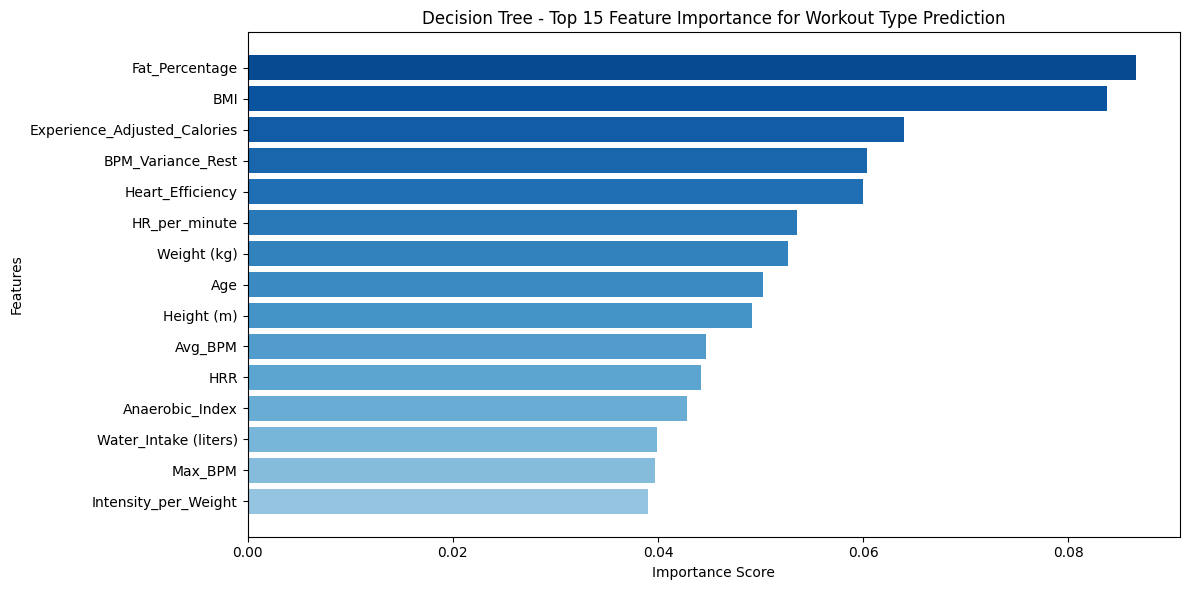

In [17]:
# Feature Importance Visualization
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(15)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_features)))
plt.barh(top_features['Feature'], top_features['Importance'], color=colors[::-1])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Decision Tree - Top 15 Feature Importance for Workout Type Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('dt_workout_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

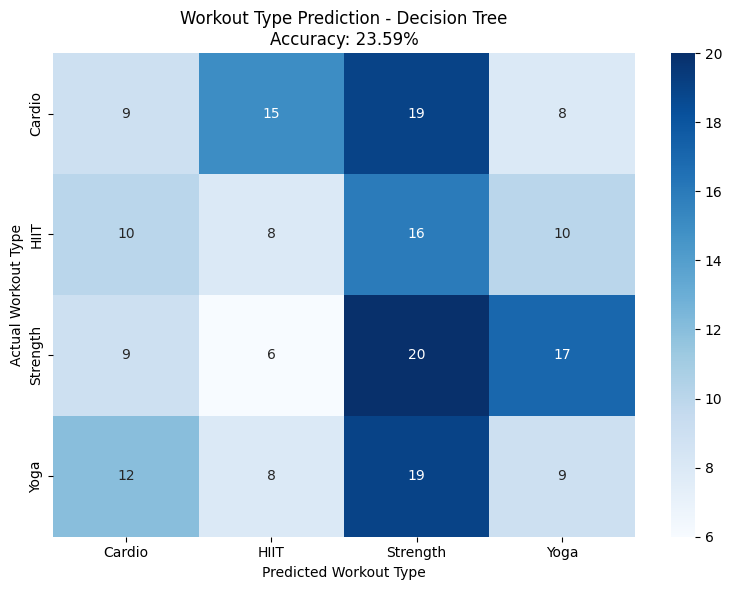

In [18]:
# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_workout.classes_,
            yticklabels=le_workout.classes_)
plt.title(f'Workout Type Prediction - Decision Tree\nAccuracy: {best_accuracy:.2%}')
plt.xlabel('Predicted Workout Type')
plt.ylabel('Actual Workout Type')
plt.tight_layout()
plt.savefig('dt_workout_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

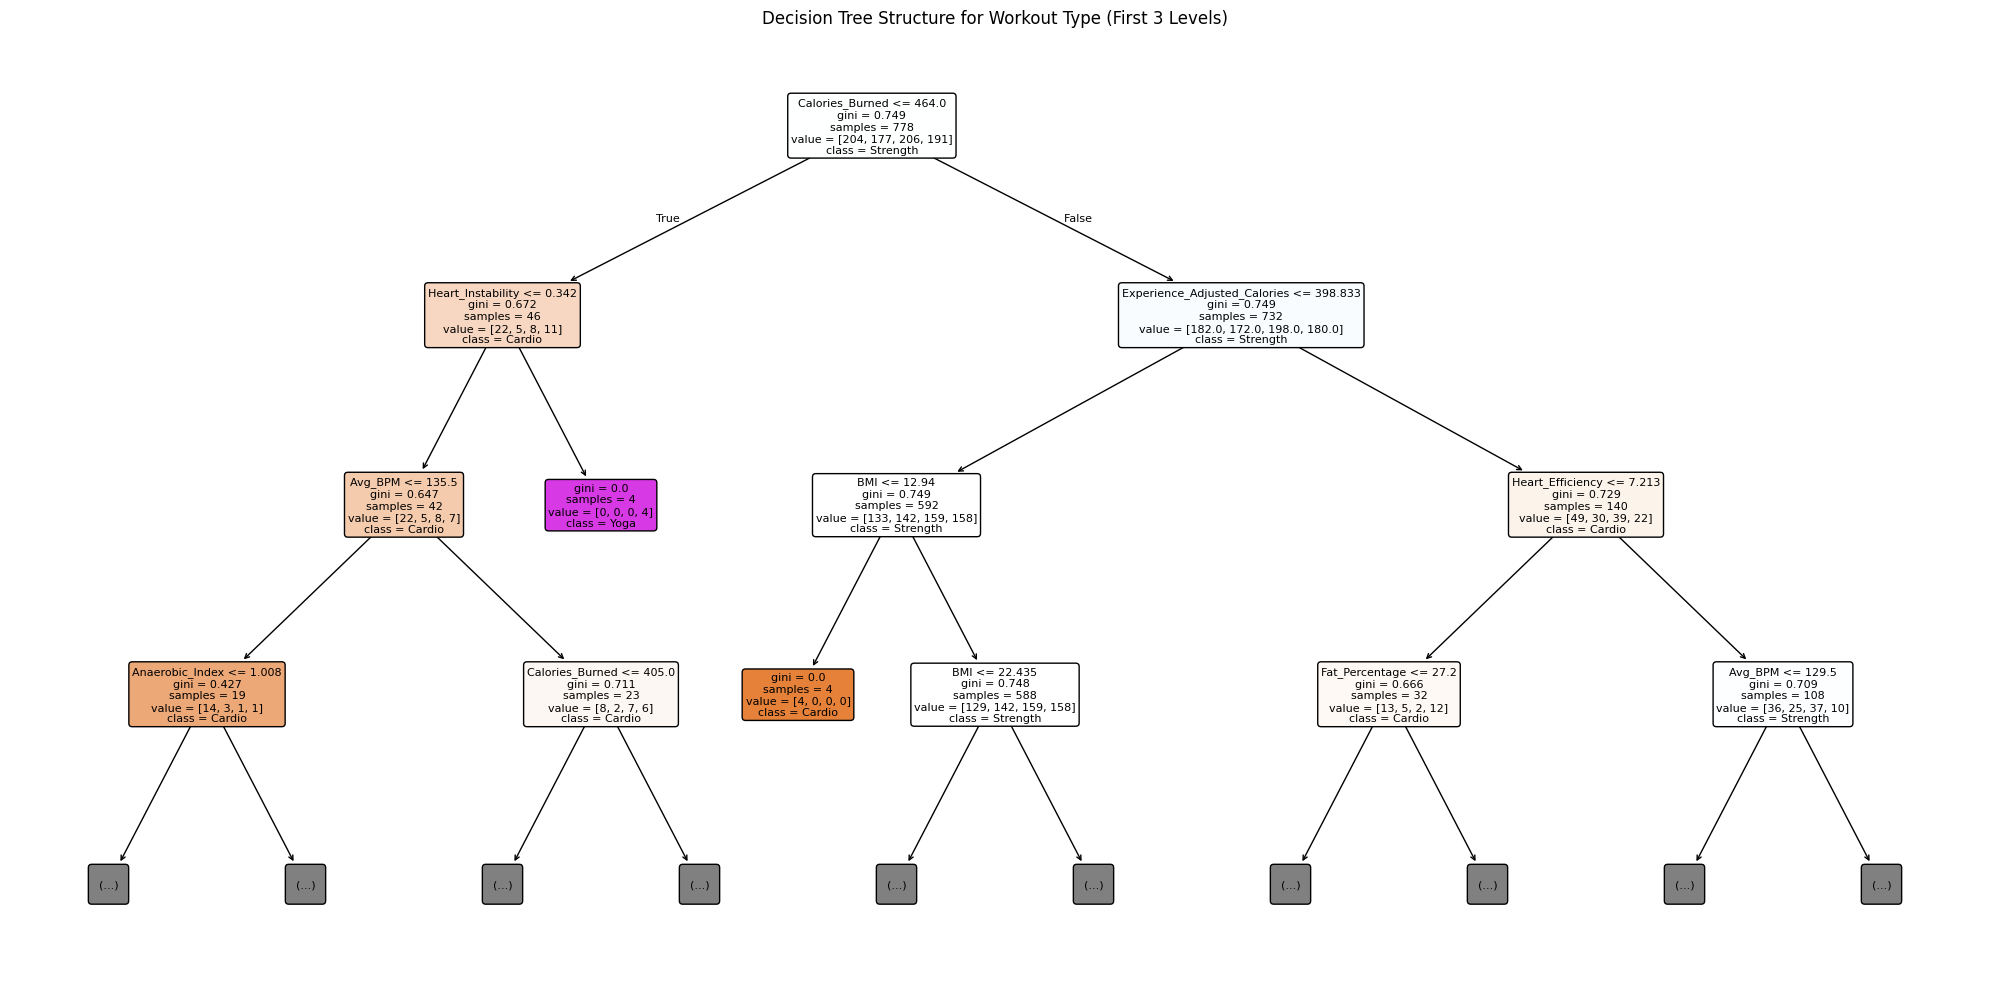

In [19]:
# Tree Structure
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model,
          feature_names=feature_cols,
          class_names=le_workout.classes_,
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=8)
plt.title('Decision Tree Structure for Workout Type (First 3 Levels)')
plt.tight_layout()
plt.savefig('dt_workout_tree_structure.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
# Model Özeti
print("\n" + "="*70)
print("DECISION TREE MODEL ÖZETİ (WORKOUT TYPE)")
print("="*70)

print(f"\n Model Bilgileri:")
print(f"   - Model: Decision Tree Classifier")
print(f"   - En iyi parametreler: {grid_search.best_params_}")
print(f"   - Ağaç derinliği: {best_dt_model.get_depth()}")
print(f"   - Yaprak sayısı: {best_dt_model.get_n_leaves()}")

print(f"\n Performans Metrikleri:")
print(f"   - Train Accuracy: {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"   - Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"   - CV Mean Accuracy: {grid_search.best_score_:.4f}")

print(f"\n En Önemli 5 Feature:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f}")



DECISION TREE MODEL ÖZETİ (WORKOUT TYPE)

 Model Bilgileri:
   - Model: Decision Tree Classifier
   - En iyi parametreler: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
   - Ağaç derinliği: 15
   - Yaprak sayısı: 200

 Performans Metrikleri:
   - Train Accuracy: 0.8535 (85.35%)
   - Test Accuracy: 0.2359 (23.59%)
   - CV Mean Accuracy: 0.2841

 En Önemli 5 Feature:
   - Fat_Percentage: 0.0865
   - BMI: 0.0837
   - Experience_Adjusted_Calories: 0.0639
   - BPM_Variance_Rest: 0.0603
   - Heart_Efficiency: 0.0600
